# **Kaggle Mini-Project: GAN, Monet Painting Project**

### **Ted Baird**

This Jupyter notebook will be split into multiple sections. They are:

1. Problem and Data Description
2. Exploratory Data Analysis
3. CNN Model Architecture
4. Results and Analysis
5. Conclusion

## Section 1: Problem and Data Description

The Kaggle project information can be found here: 


https://www.kaggle.com/competitions/gan-getting-started

From the course instructions: 
-   We will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN). Kaggle introduces an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images. Please have a close look at their explanation here: 
https://www.kaggle.com/c/gan-getting-started/overview/evaluation
-   Note: This assignment has recently been updated to use Kaggle's GAN getting started competition, which is about changing styles of photos to Monet's painting. 

In [95]:
#Import the required libraries

import numpy as np
import pandas as pd
import os
import math
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
import json, PIL, shutil, re, imageio, glob
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
#from kaggle_datasets import KaggleDatasets
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage






In this section I will describe the size, dimension, structure, etc., of the data. 

In [73]:
BASE_PATH = '/Users/tedbaird/Desktop/NN Week 5 GAN/gan-getting-started/'
MONET_PATH = os.path.join(BASE_PATH, 'monet_jpg/')
PHOTO_PATH = os.path.join(BASE_PATH, 'photo_jpg/')

In [74]:
def show_folder_info(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f'shape: {size}\tcount: {count}')


print('Monet images:')
show_folder_info(MONET_PATH)

print('Photo images:')
show_folder_info(PHOTO_PATH)

Monet images:
shape: (256, 256, 3)	count: 300
Photo images:
shape: (256, 256, 3)	count: 7038


## Section 2: Exploratory Data Analysis

In this section I will describe any data cleaning procedures and show some visualizations of the data. Based on this exploration, I will answer the question: What is the plan of analysis?

Based on this EDA, what is the plan of analysis? 



In [75]:
#visualization of paintings and photos
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

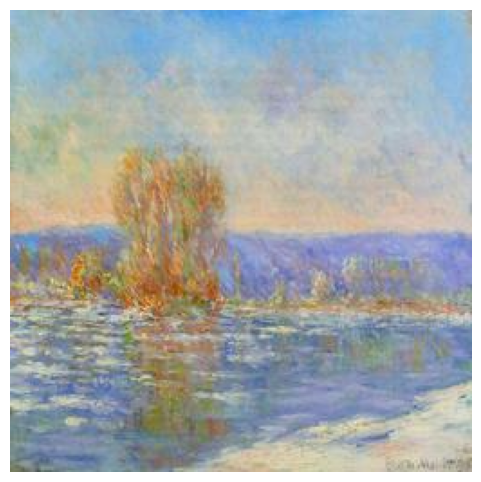

In [76]:
#random painting
batch_visualization(MONET_PATH, 1, is_random=True, figsize=(6, 6))

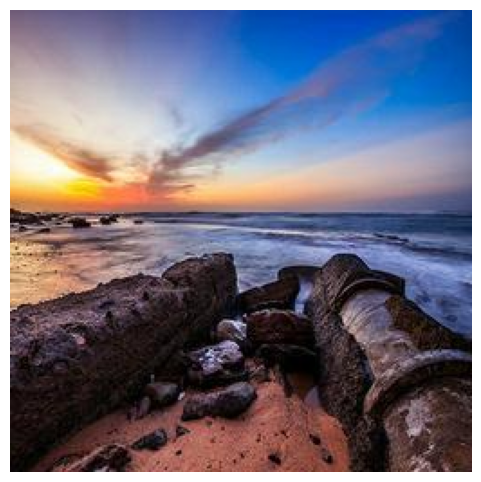

In [77]:
#random photo
batch_visualization(PHOTO_PATH, 1, is_random=True, figsize=(6, 6))


In [78]:
# Function to plot RGB histograms
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    colors = ['red', 'green', 'blue']
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis('off')
    
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    plt.show()

586acab7c5.jpg


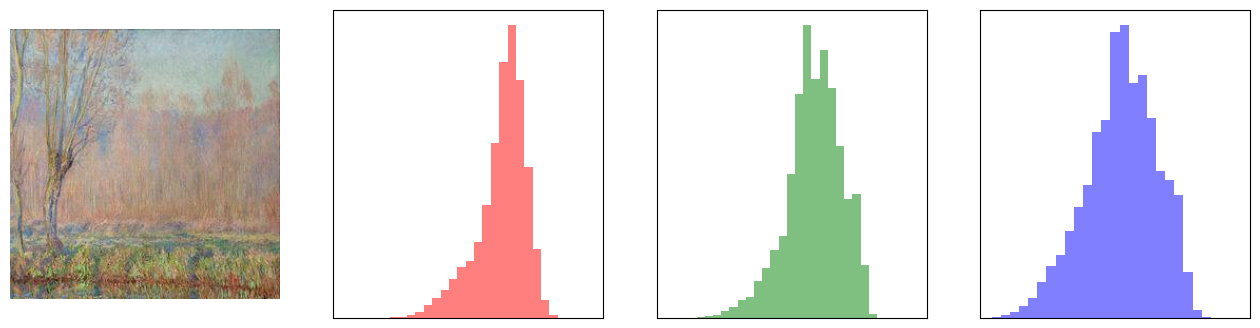

In [79]:
#Print RGB histograms of random Monet paintings

path = MONET_PATH

def randomize_file():
	return random.choice(os.listdir(path))

def print_random_filename(random_file):
	random_filename = random_file.split(".jpg")[0]
	print(random_filename)

random_file = random.choice(os.listdir(path))

print(random_file)

monet_img_path = '/Users/tedbaird/Desktop/NN Week 5 GAN/gan-getting-started/monet_jpg/'
color_hist_visualization(monet_img_path + random_file)


afabae968b.jpg


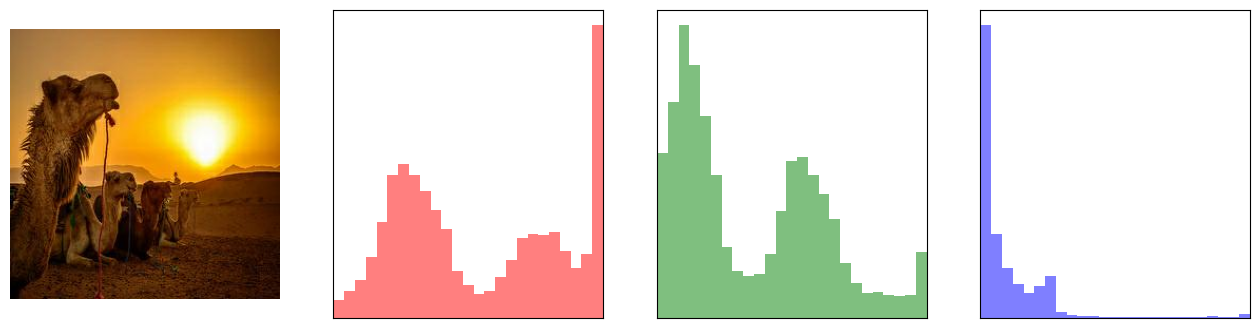

In [93]:
#Print RGB histograms of random photos

path = PHOTO_PATH

def randomize_file():
	return random.choice(os.listdir(path))

def print_random_filename(random_file):
	random_filename = random_file.split(".jpg")[0]
	print(random_filename)

random_file = random.choice(os.listdir(path))

print(random_file)

photo_img_path = '/Users/tedbaird/Desktop/NN Week 5 GAN/gan-getting-started/photo_jpg/'
color_hist_visualization(photo_img_path + random_file)

## Section 3: Model Architecture

Here I describe the model architecture 


In [85]:
#Load and preprocess the data

class MonetPhotoDataset(Dataset):
    def __init__(self, monet_path, photo_path, transform=None):
        self.monet_path = monet_path
        self.photo_path = photo_path
        self.monet_images = os.listdir(monet_path)
        self.photo_images = os.listdir(photo_path)
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        monet_img_name = os.path.join(self.monet_path, self.monet_images[idx])
        photo_img_name = os.path.join(self.photo_path, self.photo_images[idx])

        monet_img = Image.open(monet_img_name).convert('RGB')
        photo_img = Image.open(photo_img_name).convert('RGB')

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return monet_img, photo_img

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create dataset and dataloaders
dataset = MonetPhotoDataset(monet_path=MONET_PATH, photo_path=PHOTO_PATH, transform=transform)

# Set batch size
batch_size = 4

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [86]:
#Define the Generator and Discriminator

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Residual connection
        return out

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, num_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Downsampling
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256, 256) for _ in range(num_residual_blocks)]
        )

        # Upsampling
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.conv_out = nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.downsample(x)
        x = self.residual_blocks(x)
        x = self.upsample(x)

        x = self.conv_out(x)
        x = self.tanh(x)

        return x

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)

        return x


In [87]:
#define the loss functions and optimizers 

# Define the adversarial loss (Binary Cross Entropy)
adversarial_loss = nn.BCEWithLogitsLoss()

# Define the cycle-consistency loss (L1 loss)
cycle_consistency_loss = nn.L1Loss()

# Define lambda weight for the cycle-consistency loss
lambda_cycle = 10.0

# Initialize generator and discriminator networks
generator_AB = Generator(input_channels=3, output_channels=3)
generator_BA = Generator(input_channels=3, output_channels=3)
discriminator_A = Discriminator(input_channels=3)
discriminator_B = Discriminator(input_channels=3)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_AB.to(device)
generator_BA.to(device)
discriminator_A.to(device)
discriminator_B.to(device)

# Define optimizers for the generators and discriminators
optimizer_generator = optim.Adam(
    list(generator_AB.parameters()) + list(generator_BA.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999),
)
optimizer_discriminator_A = optim.Adam(
    discriminator_A.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_discriminator_B = optim.Adam(
    discriminator_B.parameters(), lr=0.0002, betas=(0.5, 0.999)
)

# Learning rate schedulers (optional)
lr_scheduler_generator = optim.lr_scheduler.LambdaLR(
    optimizer_generator, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100.0
)
lr_scheduler_discriminator_A = optim.lr_scheduler.LambdaLR(
    optimizer_discriminator_A, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100.0
)
lr_scheduler_discriminator_B = optim.lr_scheduler.LambdaLR(
    optimizer_discriminator_B, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100.0
)


In [90]:
#Training Loop

# Number of training epochs
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    for i, (real_A, real_B) in enumerate(dataloader):
        # Move real images to device (GPU if available)
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # Adversarial ground truths
        valid = torch.ones((real_A.size(0), 1, 29, 29)).to(device)
        fake = torch.zeros((real_A.size(0), 1, 29, 29)).to(device)

        ### Train Generators ###
        optimizer_generator.zero_grad()

        # Identity loss (optional, helps to preserve colors)
        identity_A = generator_BA(real_A)
        loss_identity_A = cycle_consistency_loss(identity_A, real_A)

        identity_B = generator_AB(real_B)
        loss_identity_B = cycle_consistency_loss(identity_B, real_B)

        # Adversarial loss
        fake_B = generator_AB(real_A)
        loss_GAN_AB = adversarial_loss(discriminator_B(fake_B), valid)

        fake_A = generator_BA(real_B)
        loss_GAN_BA = adversarial_loss(discriminator_A(fake_A), valid)

        # Cycle consistency loss
        recovered_A = generator_BA(fake_B)
        loss_cycle_A = cycle_consistency_loss(recovered_A, real_A) * lambda_cycle

        recovered_B = generator_AB(fake_A)
        loss_cycle_B = cycle_consistency_loss(recovered_B, real_B) * lambda_cycle

        # Total generator loss
        loss_generator = (
            loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B + loss_identity_A + loss_identity_B
        )

        # Backward pass and optimization
        loss_generator.backward()
        optimizer_generator.step()

        ### Train Discriminator A ###
        optimizer_discriminator_A.zero_grad()

        # Real loss
        loss_real = adversarial_loss(discriminator_A(real_A), valid)

        # Fake loss
        fake_A = generator_BA(real_B).detach()
        loss_fake = adversarial_loss(discriminator_A(fake_A), fake)

        # Total discriminator A loss
        loss_discriminator_A = 0.5 * (loss_real + loss_fake)

        # Backward pass and optimization
        loss_discriminator_A.backward()
        optimizer_discriminator_A.step()

        ### Train Discriminator B ###
        optimizer_discriminator_B.zero_grad()

        # Real loss
        loss_real = adversarial_loss(discriminator_B(real_B), valid)

        # Fake loss
        fake_B = generator_AB(real_A).detach()
        loss_fake = adversarial_loss(discriminator_B(fake_B), fake)

        # Total discriminator B loss
        loss_discriminator_B = 0.5 * (loss_real + loss_fake)

        # Backward pass and optimization
        loss_discriminator_B.backward()
        optimizer_discriminator_B.step()

        # Print training information
        if i % 1 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] "
                f"[Batch {i}/{len(dataloader)}] "
                f"[D A Loss: {loss_discriminator_A.item():.4f}] "
                f"[D B Loss: {loss_discriminator_B.item():.4f}] "
                f"[G Loss: {loss_generator.item():.4f}]"
            )

    # Update learning rate scheduler
    lr_scheduler_generator.step()
    lr_scheduler_discriminator_A.step()
    lr_scheduler_discriminator_B.step()

# Save the trained models
torch.save(generator_AB.state_dict(), 'generator_AB.pth')
torch.save(generator_BA.state_dict(), 'generator_BA.pth')
torch.save(discriminator_A.state_dict(), 'discriminator_A.pth')
torch.save(discriminator_B.state_dict(), 'discriminator_B.pth')


[Epoch 0/1] [Batch 0/75] [D A Loss: 0.6526] [D B Loss: 0.6699] [G Loss: 4.9373]
[Epoch 0/1] [Batch 1/75] [D A Loss: 0.6382] [D B Loss: 0.6720] [G Loss: 5.2847]
[Epoch 0/1] [Batch 2/75] [D A Loss: 0.6334] [D B Loss: 0.6846] [G Loss: 4.6113]
[Epoch 0/1] [Batch 3/75] [D A Loss: 0.6602] [D B Loss: 0.7050] [G Loss: 4.2239]
[Epoch 0/1] [Batch 4/75] [D A Loss: 0.6726] [D B Loss: 0.6941] [G Loss: 4.4549]
[Epoch 0/1] [Batch 5/75] [D A Loss: 0.7121] [D B Loss: 0.6726] [G Loss: 4.3775]
[Epoch 0/1] [Batch 6/75] [D A Loss: 0.6824] [D B Loss: 0.6760] [G Loss: 3.9198]
[Epoch 0/1] [Batch 7/75] [D A Loss: 0.6565] [D B Loss: 0.6620] [G Loss: 4.3474]
[Epoch 0/1] [Batch 8/75] [D A Loss: 0.6577] [D B Loss: 0.6450] [G Loss: 5.0454]
[Epoch 0/1] [Batch 9/75] [D A Loss: 0.6507] [D B Loss: 0.6513] [G Loss: 4.6784]
[Epoch 0/1] [Batch 10/75] [D A Loss: 0.6664] [D B Loss: 0.6579] [G Loss: 4.5135]
[Epoch 0/1] [Batch 11/75] [D A Loss: 0.6379] [D B Loss: 0.6611] [G Loss: 4.9984]
[Epoch 0/1] [Batch 12/75] [D A Loss: 0

## Section 4: Results and Analysis



In [91]:
#Test model and make function to generate Monet-style paintings

# Load the trained generator model
generator_AB = Generator(input_channels=3, output_channels=3)
generator_AB.load_state_dict(torch.load('generator_AB.pth'))
generator_AB.eval()

# Define the transformation for test images
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to generate Monet-style paintings
def generate_monet_style(input_photo_path, generator_model, save_path='output_monet.jpg'):
    input_photo = Image.open(input_photo_path).convert('RGB')
    input_photo_tensor = transform_test(input_photo).unsqueeze(0)

    # Move input to device if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_photo_tensor = input_photo_tensor.to(device)
    generator_model = generator_model.to(device)

    # Generate Monet-style painting
    with torch.no_grad():
        output_monet_tensor = generator_model(input_photo_tensor)

    # Convert the generated output to a PIL image
    output_monet_pil = ToPILImage()(output_monet_tensor.squeeze(0).cpu())

    # Save or display the result
    output_monet_pil.save(save_path)
    plt.imshow(output_monet_pil)
    plt.show()

dc0f97a1aa.jpg


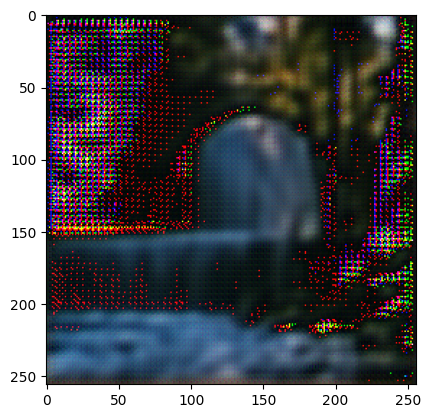

In [101]:
# Test the generator on a random photo

path = PHOTO_PATH

def randomize_file():
	return random.choice(os.listdir(path))

def print_random_filename(random_file):
	random_filename = random_file.split(".jpg")[0]
	print(random_filename)

random_file = random.choice(os.listdir(path))

print(random_file)

photo_img_path = '/Users/tedbaird/Desktop/NN Week 5 GAN/gan-getting-started/photo_jpg/'

input_photo_path = photo_img_path + random_file
generate_monet_style(input_photo_path, generator_AB)

## Section 5: Conclusion

What did and did not help improve the performance of your models? What improvements could you try in the future?

The photos generated are far from Monet-esque. I may need to make some serious changes to the model. 

What may have gone wrong: 

Architecture Design: A different and well-designed generator and discriminator architecture is crucial for the success of a CycleGAN. Experimenting with different architectures, adjusting the number of layers, or exploring more advanced architectures could lead to improvements.
Hyperparameter Tuning: Proper tuning of hyperparameters such as learning rates, cycle-consistency weights, and adversarial loss weights is essential. I would need to fine-tune hyperparameters based on the performance on a validation set. Conducting a systematic search might reveal better configurations.
Mode Collapse: Mode collapse can happen where the generator produces limited variations of outputs. I should have experimented with different training strategies, augmentations, or modifications to the loss functions to address mode collapse.

Areas for improvement:


Data Quality and Quantity: Having a diverse and representative dataset of Monet paintings and photos is crucial, which we have here. But I need to ensure balanced representation and consider other pre-processing and data augmentation techniques.
Adversarial Training: Training the model with adversarial loss helps in generating more realistic images. I need to experiment with adversarial training techniques and potentially adjust the weights of adversarial loss terms.
Transfer Learning: I should investigate the use of transfer learning from pre-trained models on related tasks to boost performance.
Attention Mechanisms: I should consider incorporating attention mechanisms to allow the model to focus on different parts of the image during generation.
More Complex Architectures: I should also experiment with more complex generator and discriminator architectures or consider other state-of-the-art GAN architectures.
Improved Loss Functions: Finally I should explore alternative loss functions or combinations of losses to better capture the desired properties in the generated images.





**References**

-   Starter notebook from: https://www.kaggle.com/code/swepat/cyclegan-to-generate-monet-style-images/notebook
-   Getting a random image from a folder: https://gist.github.com/slavakurilyak/d3418446179f98cde5b7d6b53eefa09d
-   CycleGAN paper: https://junyanz.github.io/CycleGAN/
-   CycleGAN tutorial: https://www.tensorflow.org/tutorials/generative/cyclegan


